In [1]:
%pylab inline
%run filter_setup.py
import sncosmo

from glob import glob
import copy


import pymc3 as pm
import theano
import theano.tensor as T
from theano.compile.ops import as_op
import scipy.optimize as optimize
from astropy import cosmology

from astropy.table import Column
from collections import OrderedDict as odict


from astropy.constants import c as sol

from cosmo import distmod, distmodW

from data_routine import drop, add_dropped, preProcessData

/usr/local/lib/python2.7/site-packages/matplotlib/font_manager.py:273: UserWarning: Matplotlib is building the font cache using fc-list. This may take a moment.
  warnings.warn('Matplotlib is building the font cache using fc-list. This may take a moment.')


Populating the interactive namespace from numpy and matplotlib


In [2]:
glob

<function glob.glob>

In [3]:
import seaborn as sns
sns.set_style('white')

In [4]:
genfromtxt('dropped.txt')

array([ 599.,  684.])

In [5]:
lc_files=array(glob("jla_light_curves/lc*.list"))[drop()]

In [6]:
lc_files[333]

'jla_light_curves/lc-SDSS15171.list'

In [7]:
LC =preProcessData( sncosmo.io.read_lc(lc_files[333], format='salt2') )

In [8]:
salt.set(z=LC.meta['Z_HELIO'], mwebv=LC.meta['MWEBV'])
res, fitted_model = sncosmo.fit_lc(LC, salt, ['t0', 'x0', 'x1', 'c'])

NameError: name 'salt' is not defined

In [ ]:
_ = sncosmo.plot_lc(LC, model=fitted_model, errors=res.errors)

## Filter Setup

## Define the model

In [9]:
# Fit the lc
# First need to add MW dust correction to model
dust = sncosmo.CCM89Dust()
salt = sncosmo.Model(source='salt2',
                      effects=[dust],
                      effect_names=['mw'],
                      effect_frames=['obs'])

## Load the data

In [10]:
lc_files=array(glob("jla_light_curves/lc*.list"))[drop()]
rndLC_index =random.choice(range(len(lc_files)),replace=False,size=500)

lc_files = lc_files[rndLC_index]

data=map(lambda f: sncosmo.io.read_lc(f, format='salt2') ,lc_files)
tStarts = map(lambda x: x['Date'][0],data )

nData = len(data)

In [11]:
from astropy.table import Table
jlaSet = Table.read("jla_lcparams.txt",format='ascii')

tmp =[]
for x in jlaSet['name']:
    if "SDSS" in x:
        tmp.append(True)
    else: tmp.append(False)
        
sdssCond=array(tmp)


#jlaSet = jlaSet[sdssCond][100:200]
jlaSet = jlaSet[drop()]
jlaSet = jlaSet[rndLC_index]


JZ=theano.shared(array(jlaSet['zcmb']))
color=theano.shared(jlaSet['color'])
dcolor=theano.shared(jlaSet['dcolor'])
x1=theano.shared(jlaSet['x1'])
dx1=theano.shared(jlaSet['dx1'])
mbObs=theano.shared(jlaSet['mb'])
dmbObs=theano.shared(jlaSet['dmb'])
nSN = len(jlaSet)

In [12]:
processedData = array(map(lambda d: preProcessData(d),data))    


params = []
muB = []
muBerr=[]
errC=[]
errX1=[]

survery=[]

for lc in processedData:
    
   
    
    
    
       
    # redshift and MW E(B-V) were in file header 
    salt = sncosmo.Model(source='salt2',
                      effects=[dust],
                      effect_names=['mw'],
                      effect_frames=['obs'])
    salt.set(z=lc.meta['Z_HELIO'], mwebv=lc.meta['MWEBV'])
    res, fitted_model = sncosmo.fit_lc(lc, salt, ['t0', 'x0', 'x1', 'c'])
    
    
    
    errC.append(res['errors']['c'])
    errX1.append(res['errors']['x1'])
    
    tmp = fitted_model.parameters[[0,1,2,3,4]].tolist()
    #tmp[0]=lc.meta['Z_CMB']
    #fitted_model.set(z=0.)
    
    param = odict()
    for name in res['vparam_names']:
        param[name] = res['parameters'][res['param_names'].index(name)]
    
    muB.append(  _get_bandmag('bessellb', 'ab', **param))
    grad = _get_bandmag_gradient('bessellb', 'ab', param, res['errors'], {})
    J = np.array([[1,0,0,0],
                      [0,1,0,0],
                      [0,0,1,0],
                      [0,0,0,1],
                     grad])
    cov = J.dot(res['covariance']).dot(J.T)
    
    muBerr.append(np.sqrt(cov[4,4]))
    
    
    params.append(tmp)
    #survery.append(lc.meta['SURVEY'])
    
    survery.append(lc['Filter'][0].split('::')[0])
    


params=array(params)
muB=array(muB)
muBerr=array(muBerr)
allC = params[:,4]
allX1 = params[:,3]
allX0 = params[:,2]
allZ = array(jlaSet['zcmb'])#params[:,0]

filt = logical_and(muB>24,allZ<.4)
filt2 = logical_and(muB<18,allZ>.2)
filt = logical_and(~filt,~filt2)



errC=array(errC)
errX1=array(errX1)

/usr/local/lib/python2.7/site-packages/sncosmo/fitting.py:132: RuntimeWarning: Dropping following bands from data: 'SDSS::z'(out of model wavelength range)
  "(out of model wavelength range)", RuntimeWarning)
/usr/local/lib/python2.7/site-packages/sncosmo/fitting.py:132: RuntimeWarning: Dropping following bands from data: 'MEGACAMPSF::g'(out of model wavelength range)
  "(out of model wavelength range)", RuntimeWarning)
/usr/local/lib/python2.7/site-packages/sncosmo/fitting.py:132: RuntimeWarning: Dropping following bands from data: 'MEGACAMPSF::z'(out of model wavelength range)
  "(out of model wavelength range)", RuntimeWarning)


In [13]:
pal=sns.color_palette('Set1',8)
cols={}
for i,s in enumerate(unique(survery)):
    cols[s]=pal[i]
    
    



In [14]:
survery = array(survery)

shoot4 = survery == 'STANDARD'

In [15]:
wh=2
jlaSet[filt]

name,zcmb,zhel,dz,mb,dmb,x1,dx1,color,dcolor,3rdvar,d3rdvar,tmax,dtmax,cov_m_s,cov_m_c,cov_s_c,set,ra,dec,biascor
str9,float64,float64,int64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,int64,float64,float64,float64
05D3lb,0.647639,0.647,0,23.898505,0.09193,0.310288,0.183447,0.032706,0.050872,8.931,0.23,53528.654917,0.252784,0.001308,0.000639,7.4e-05,1,214.382325,53.167928,-0.001381
05D4dt,0.405478,0.407,0,22.801779,0.086962,-0.988887,0.107135,-0.047526,0.024506,10.429,0.115,53609.569177,0.172918,0.000412,0.000478,-6e-05,1,333.607695,-17.671111,0.000785
03D4di,0.896944,0.899,0,24.333328,0.109618,1.454285,0.416048,-0.084188,0.064346,9.879,0.0635,52901.059111,0.533964,0.009161,-0.001625,0.003864,1,333.542663,-17.506617,-0.021066
SDSS2561,0.11741,0.11813,0,19.784621,0.112518,-0.082681,0.115449,0.039633,0.024351,10.574,0.086,53639.254293,0.145747,0.000652,0.00059,0.000178,2,46.343418,0.858359,-0.001213
SDSS2031,0.15186,0.153,0,19.681123,0.112035,0.506889,0.140311,-0.129527,0.022797,9.275,0.192,53636.918572,0.139273,0.000912,0.000472,1e-05,2,-47.95681,-1.171422,-0.001219
SDSS16165,0.15596,0.157,0,20.146078,0.112725,0.344199,0.222938,-0.032,0.024798,5.0,10.0,54052.896254,0.192094,0.002637,0.000594,0.001305,2,30.733135,-0.533872,-0.001206
SDSS17274,0.17658,0.178,0,20.397033,0.1635,1.957731,0.536123,-0.136685,0.077192,8.963,0.141,54352.879758,2.336975,-0.013374,0.008604,-0.011383,2,-0.658497,0.105858,-0.001107
SDSS13152,0.2056,0.207,0,20.662469,0.113718,0.25867,0.243737,0.007696,0.029325,9.363,0.199,54001.23227,0.196075,0.003031,0.000761,0.000829,2,7.052111,0.11801,-0.000894
06D4co,0.435446,0.437,0,22.524456,0.086944,-0.395993,0.094666,-0.046795,0.023301,10.627,0.1515,53940.305517,0.159309,0.000118,0.000437,-0.000116,1,333.860492,-17.869185,0.001231


In [16]:
filt = logical_and(muB>24,allZ<.4)
filt2 = logical_and(muB<18,allZ>.2)
filt = logical_and(~filt,~filt2)


[ 23.75577472  22.64591914  24.13508166  19.64646476  19.52949182
  19.98214382  20.31888213  20.51159456  22.36092821  21.62142191
  21.2146189   15.97120388  14.51908538  24.06187683  17.96191894
  24.82168719  16.74325216  18.99223199  23.68094982  14.91831987
  24.72041952  24.31467931  16.12831439  20.09274703  15.94306496
  19.88087784  23.90868409  23.8925062   18.48052464  20.09057268
  20.4506899   21.38013613  22.74969529  21.05798997  15.61991278
  23.0554391   14.97182157  21.36319418  20.58566035  19.22909809
  16.67492612  22.51700218  19.26988015  24.03028445  20.28743244
  19.65793964  20.1266617   24.62791165  20.76101311  15.59708021
  20.06765429  23.69341128  17.56042365  19.54628162  17.74706783
  14.65378825  20.27301825  23.46858407  23.99188124  20.19849938
  24.22512751  21.93656819  23.24659415  21.62044481  22.29174511
  17.00986923  19.27132472  20.97375586  15.60247334  21.4655261
  15.47774263  21.37068978  20.9331432   24.63400129  20.41573059
  23.791217

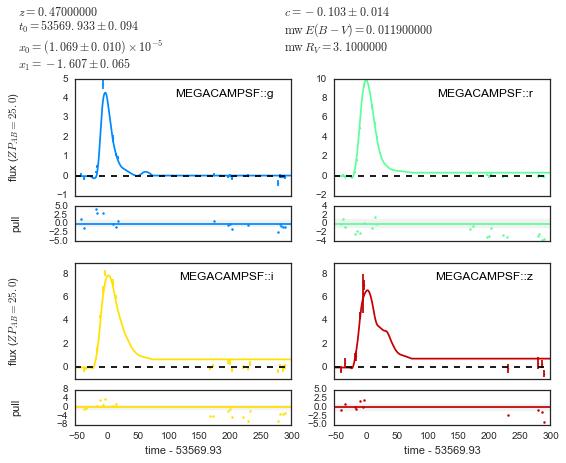

In [19]:


lc=processedData[150]
print muB[filt]
#lc = lc[lc['Filter'] != '4SHOOTER2::Us'] 
salt = sncosmo.Model(source='salt2',
                      effects=[dust],
                      effect_names=['mw'],
                      effect_frames=['obs'])
salt.set(z=lc.meta['Z_HELIO'], mwebv=lc.meta['MWEBV'])
res, fitted_model = sncosmo.fit_lc(lc, salt,['c','t0','x1','x0'])
_ = sncosmo.plot_lc(lc, model=fitted_model, errors=res.errors)

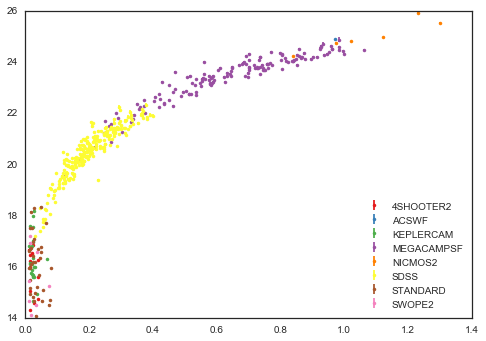

In [20]:
zGrid = linspace(0.,1.45)

for sur in unique(survery):
    
    tt= survery[filt] == sur
    

    errorbar(allZ[filt][tt],muB[filt][tt],yerr=muBerr[filt][tt],fmt='.',color=cols[sur],label=sur)

#errorbar(allZ,jlaSet['mb'],yerr=jlaSet['dmb'],fmt='.',color='k')
legend(loc=4)
#spefCosmo = cosmology.FlatLambdaCDM(H0=72., Om0=0.3)
#plot(zGrid,spefCosmo.distmod(zGrid).value-19.1,'r')

## Utility OPS for theano

In [21]:



lcModel= pm.Model()


allC_shared=theano.shared(allC[filt])
muB_shared=theano.shared(muB[filt])
allX1_shared=theano.shared(allX1[filt])
errC_shared = theano.shared(errC[filt])
errX1_shared = theano.shared(errX1[filt])
muBerr_shared = theano.shared(muBerr[filt])

nData = len(muBerr[filt])
with lcModel:

    OmegaM = pm.Uniform("OmegaM",lower=0,upper=1.)
    M0      = pm.Uniform("M0",lower=-20.,upper=-18.)
    taninv_alpha = pm.Uniform("taninv_alpha",lower=-.2,upper=.3)
    taninv_beta = pm.Uniform("taninv_beta",lower=-1.4,upper=1.4)
    sysScat_log = pm.Uniform("sysScat_log",lower=log10(0.05),upper=0)
   
    
   
    
                      
    xm=pm.Cauchy('xm',alpha=0,beta=1)
    cm=pm.Cauchy('cm',alpha=0,beta=0.3)
    Rx_log=pm.Uniform('Rx_log',lower=-0.5,upper=0.5)
    Rc_log=pm.Uniform('Rc_log',lower=-1.5,upper=1.5)
    
   
    alpha=pm.Deterministic('alpha',T.tan(taninv_alpha))
    beta=pm.Deterministic('beta',T.tan(taninv_beta))
    Rx=pm.Deterministic("Rx",10**Rx_log)
    Rc=pm.Deterministic("Rc",10**Rc_log)
    sysScat = pm.Deterministic('sysScat',10**sysScat_log)

    x_true  = pm.Normal('x_true',mu=xm, sd=Rx,shape=nData)
    c_true  = pm.Normal('c_true',mu=cm, sd=Rc,shape=nData)
    M_true  = pm.Normal('M_true',mu=M0,sd=sysScat,shape=nData)
    
    #dm = get_distMod(OmegaM)
    dm = distmod(OmegaM,allZ[filt])
   
    #mb = pm.Normal("mb",mu= M + dm - alpha*x_true + beta*c_true,sd=sysScat,shape=nData)
    mb = pm.Deterministic("mb",M_true + dm - alpha*x_true + beta*c_true)
    
    obsc=pm.Normal("obsc",mu=c_true,sd=errC_shared, observed=allC_shared)
    obsx=pm.Normal("obsx",mu=x_true,sd=errX1_shared, observed=allX1_shared)
    obsm = pm.Normal("obsm",mu=mb,sd=muBerr_shared,observed=muB_shared)
  
    
    

Applied interval-transform to OmegaM and added transformed OmegaM_interval to model.
Applied interval-transform to M0 and added transformed M0_interval to model.
Applied interval-transform to taninv_alpha and added transformed taninv_alpha_interval to model.
Applied interval-transform to taninv_beta and added transformed taninv_beta_interval to model.
Applied interval-transform to sysScat_log and added transformed sysScat_log_interval to model.
Applied interval-transform to Rx_log and added transformed Rx_log_interval to model.
Applied interval-transform to Rc_log and added transformed Rc_log_interval to model.


In [ ]:
arange(1,4)

In [22]:
with lcModel:
    start=pm.find_MAP(fmin=optimize.fmin_powell)

In [ ]:
start

In [25]:
with lcModel:
    
    step=pm.NUTS(scaling=start)
    trace=pm.sample(15000,step=step,start=start,progressbar=True)

 [-----------------100%-----------------] 15000 of 15000 complete in 260.0 sec

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x15ad9c790>,
        <matplotlib.axes._subplots.AxesSubplot object at 0x13fce4410>]], dtype=object)

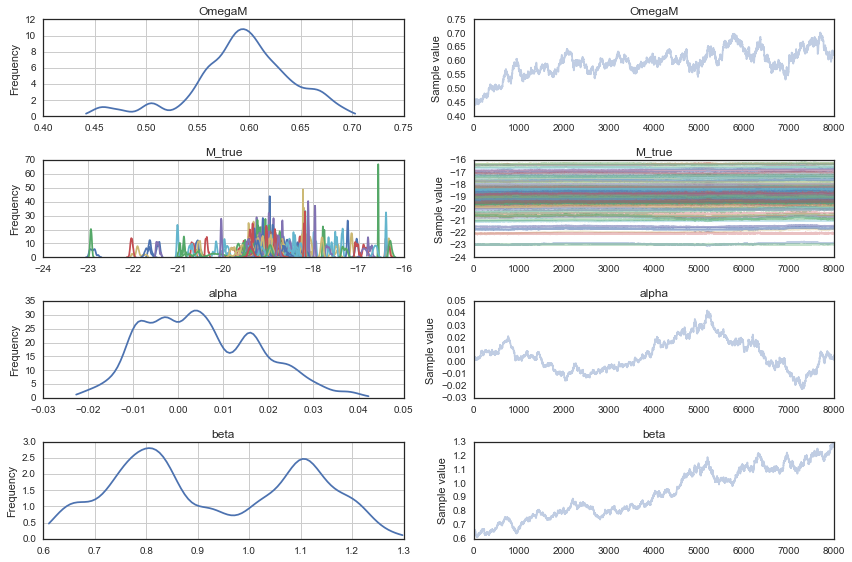

In [29]:
pm.traceplot(trace[7000:],varnames=["OmegaM","M_true",'alpha','beta'])

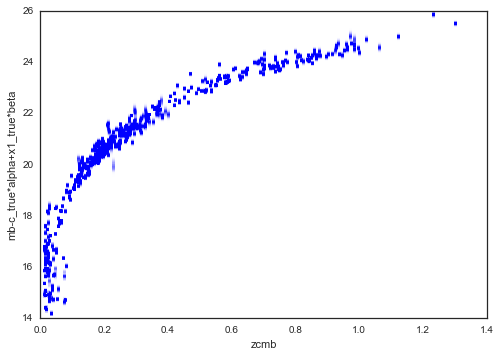

In [32]:
zGrid = linspace(0,1.4,100)

for tr in trace[7000::20]:
    
    spefCosmo = cosmology.FlatLambdaCDM(H0=72., Om0=tr['OmegaM'])
    #plot(zGrid,spefCosmo.distmod(zGrid).value+tr["M"],'r',alpha=0.01)
    plot(allZ[filt],tr['mb']-tr['c_true']*tr['beta']+tr['alpha']*tr['x_true'],'b.',alpha=0.005)
    
 


xlabel("zcmb")
ylabel("mb-c_true*alpha+x1_true*beta")

In [ ]:
df_trace = pm.trace_to_dataframe(trace[2500:])

In [ ]:
sns.pairplot(df_trace,vars=['alpha','beta','OmegaM','M'])

In [ ]:
for tr in trace[2500::10]:
    
    #spefCosmo = cosmology.FlatLambdaCDM(H0=72., Om0=tr['OmegaM'])
    plot(zGrid,distmod(tr['OmegaM'],allZ).eval()+tr["M"],'r',alpha=0.05)
    #plot(allZ,muB-allC*tr['beta']+tr['alpha']*allX1,'b.',alpha=0.05)
    
    #spefCosmo = cosmology.FlatLambdaCDM(H0=72., Om0=.3)
    #plot(zGrid,spefCosmo.distmod(zGrid).value+tr["M"],'k',alpha=0.05)
    
    
   

  

#ylim(top=25)

In [ ]:
nData

In [ ]:
nSN

In [33]:


lcModel2= pm.Model()


with lcModel2:
    
 
    OmegaM = pm.Uniform("OmegaM",lower=0,upper=1.)
    #w      = pm.Normal("w",mu=-1,sd=1)
    
    M0      = pm.Uniform("M0",lower=-20.,upper=-18.)
    
    
    taninv_alpha = pm.Uniform("taninv_alpha",lower=-.2,upper=.3)
    taninv_beta = pm.Uniform("taninv_beta",lower=-1.4,upper=1.4)
    sysScat_log = pm.Uniform("sysScat_log",lower=log10(0.5),upper=0)
   
    
   
    
                      
    xm=pm.Cauchy('xm',alpha=0,beta=1)
    cm=pm.Cauchy('cm',alpha=0,beta=0.3)
    Rx_log=pm.Uniform('Rx_log',lower=-0.5,upper=0.5)
    Rc_log=pm.Uniform('Rc_log',lower=-1.5,upper=1.5)
    
   
    alpha=pm.Deterministic('alpha',T.tan(taninv_alpha))
    beta=pm.Deterministic('beta',T.tan(taninv_beta))
    Rx=pm.Deterministic("Rx",10**Rx_log)
    Rc=pm.Deterministic("Rc",10**Rc_log)
    sysScat = pm.Deterministic('sysScat',10**sysScat_log)
    
   


    x_true  = pm.Normal('x_true',mu=xm, sd=Rx,shape=nSN)
    c_true  = pm.Normal('c_true',mu=cm, sd=Rc,shape=nSN)
    M_true  = pm.Normal('M_true',mu=M0,sd=sysScat,shape=nSN)
    
    #dm = distmodW(OmegaM,w,JZ)
    dm = distmod(OmegaM,JZ)
    #mb = pm.Normal("mb",mu=M + dm - alpha*x_true + beta*c_true,sd=sysScat,shape=nSN)
    mb = pm.Deterministic("mb",M_true + dm - alpha*x_true + beta*c_true)
    
    obsc=pm.Normal("obsc",mu=c_true,sd=dcolor, observed=color)
    obsx=pm.Normal("obsx",mu=x_true,sd=dx1, observed=x1)
    
    obsm = pm.Normal("obsm",mu=mb,sd=dmbObs,observed=mbObs)
 

Applied interval-transform to OmegaM and added transformed OmegaM_interval to model.
Applied interval-transform to M0 and added transformed M0_interval to model.
Applied interval-transform to taninv_alpha and added transformed taninv_alpha_interval to model.
Applied interval-transform to taninv_beta and added transformed taninv_beta_interval to model.
Applied interval-transform to sysScat_log and added transformed sysScat_log_interval to model.
Applied interval-transform to Rx_log and added transformed Rx_log_interval to model.
Applied interval-transform to Rc_log and added transformed Rc_log_interval to model.


In [34]:
with lcModel2:
    start2=pm.find_MAP(fmin=optimize.fmin_powell)

In [35]:
with lcModel2:
    
    #step1=pm.Slice()
    step1=pm.NUTS(scaling=start2)
    

In [40]:
with lcModel2:
    
    trace2=pm.sample(10000,step=step1,start=start2,progressbar=True)

 [-----------------100%-----------------] 10000 of 10000 complete in 237.4 sec

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x168250650>,
        <matplotlib.axes._subplots.AxesSubplot object at 0x189a9cb90>]], dtype=object)

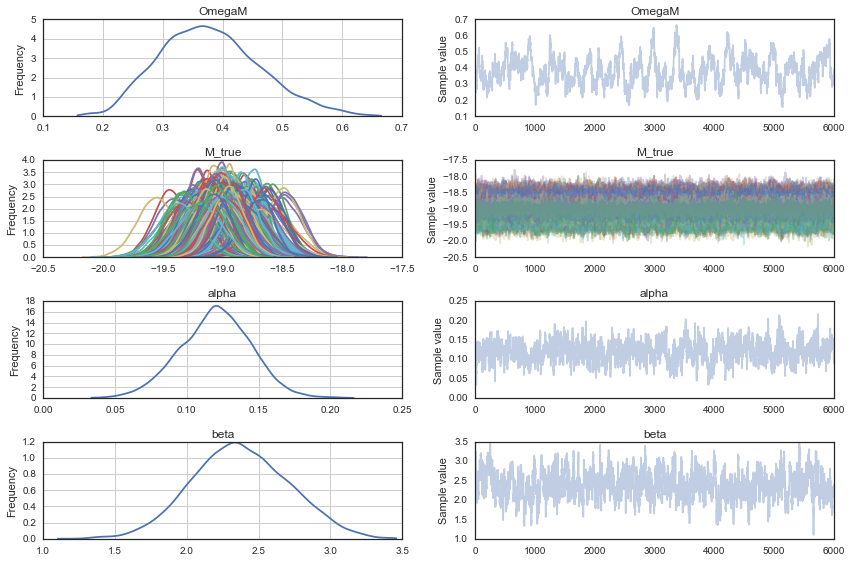

In [41]:
pm.traceplot(trace2[4000:],varnames=["OmegaM","M_true",'alpha','beta'])

In [43]:
df_trace2 = pm.trace_to_dataframe(trace2[5000:])
df_trace2.rename(columns={'alpha':r'$\alpha$','beta':r'$\beta$','OmegaM':r'$\Omega_M$'},inplace=True)

/usr/local/lib/python2.7/site-packages/matplotlib/axes/_axes.py:519: UserWarning: No labelled objects found. Use label='...' kwarg on individual plots.
  warnings.warn("No labelled objects found. "


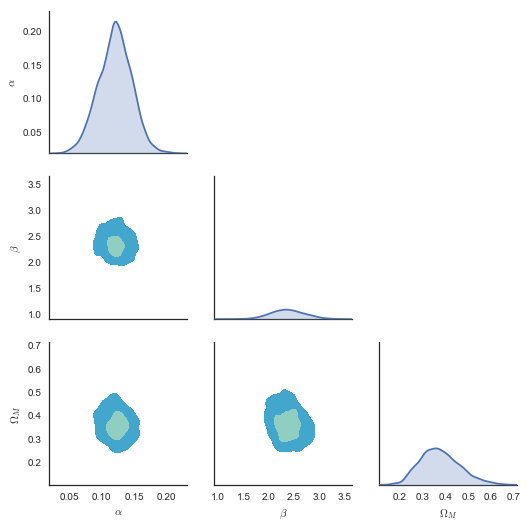

In [44]:
g = sns.PairGrid(df_trace2,vars=[r'$\alpha$',r'$\beta$',r'$\Omega_M$'])
g.map_diag(sns.kdeplot,shade=True)
g.map_offdiag(sns.kdeplot, cmap="GnBu_d", n_levels=2,shade=True,shade_lowest=False)
for i, j in zip(*np.triu_indices_from(g.axes, 1)):
    g.axes[i, j].set_visible(False)

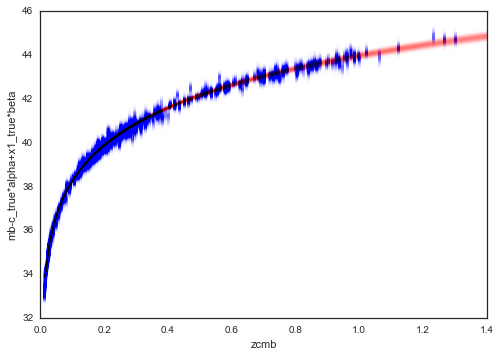

In [48]:
zGrid = linspace(0,1.4,100)

for tr in trace2[5000::10]:
    
    spefCosmo = cosmology.FlatLambdaCDM(H0=72., Om0=tr['OmegaM'])
    plot(zGrid,spefCosmo.distmod(zGrid).value,'r',alpha=0.005)
    plot(jlaSet['zcmb'],tr['mb']-tr['M0']-tr['c_true']*tr['beta']+tr['alpha']*tr['x_true'],'b.',alpha=0.005)
    
    
xlabel("zcmb")
ylabel("mb-c_true*alpha+x1_true*beta")

In [ ]:
jlaSet

In [ ]:
from scipy.interpolate import splev

In [ ]:
pm.forestplot(trace2[:2500],varnames=['c_true'])

In [ ]:
pm.forestplot(trace2[:2500],varnames=['x_true'])

In [ ]:
pm.summary(trace2[2500:],varnames=["OmegaM","M","Rx","Rc",'sysScat','alpha','beta','w','cm','xm'])

In [ ]:
scatter(color.eval(),allC)

In [ ]:
scatter(x1.eval(),allC)